In this notebook, we want to implement a classifier to evaluate the effects of pre-processing on the available data. In particular, we will study the effects of __dimensionality reduction__ obtained by feature-extraction and PCA, and evaluate whether the additional information produced by __clustering__ will help the classification algorithm.\
Finally, we will also try to implement a __perceptron__: the aim will be to demonstrate its ineffectiveness on non-linearly separable datasets.

### __Fully-Connected Feed-Forward Network__
The basic unit of a neural network is the *neuron*, which produces a scalar output $a_i(\textbf{x})$ from an input vector consisting of $d$ features,\
$\textbf{x}=(x_1, x_2, ..., x_d)$.\
The output $a_i$ depends on the specific architecture of the network, but can generally be divided into 2 transformations:
1. __Linear__ $z^{(i)}$, in the form of a scalar product between the weights associated with the neuron $\boldsymbol{w}^{(i)} = (w_1^{(i)}, w_2^{(i)}, ..., w_3^{(i)})$ and the data itself, together with a bias term:
$$z^{(i)} = \boldsymbol{w}^{(i)} \cdot \textbf{x} + b^{(i)}$$
1. __Non-linear__ $\sigma_i(z^{(i)})$: in general, this is a non-linear function in which two regimes can be observed that differentiate the final output. In our case, we are going to use the Rectified Linear Unit function (*ReLU*). Typically, this function is the same for each *hidden layer*.

The idea behind a DNN is to stratify arrays of neurons in order to obtain a hierarchical structure. In Feed Forward NNs each neuron - except those belonging to the first and last layers - receives as input the output values of the previous layer and processes them according to the function $a_i$. The *input* layer merely transforms the original data, while the *output* layer behaves like a normal classifier (in our case).\
Recall the expression for the *softmax*, the loss function of a multi-class classifier, derived from the *cross-entropy*:
$$E(\boldsymbol{w}) = - \sum_{i=1}^{n} \sum_{m=0}^{M-1} y_{im}\log{\hat{y}_{im}(\boldsymbol{w})} + (1-y_{im})\log{[1-\hat{y}_{im}(\boldsymbol{w})]}$$
where:
- $y_{im}$, one-hot vector that can take any value among M classes,
$$y_{im} = \begin{cases} 1, y_i=m \\  0, otherwise\end{cases}$$

- $\hat{y}_{im}(\boldsymbol{w}) = p(y_i = m | \boldsymbol{x}_i, \boldsymbol{w})$: probability predicted by the algorithm.

NNs learn by minimizing the loss function using gradient descent. Due to the layered structure, calculating the gradient for each neuron can be computationally difficult. NNs therefore implement the *backpropagation* algorithm for gradient computation:
$$\frac{\partial{E}}{\partial{w_{jk}^l}} = \frac{\partial{E}}{\partial{z_{j}^l}}\frac{\partial{z_j^l}}{\partial{w_{jk}^l}}$$
where $j, l$ refer to the $j$-th neuron in the $l$-th layer, $k$ refers to the $k$-th neuron in layer $l-1$.

In [111]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Fetch the data from the csv files inside the data folder named final_datasets
X_train = pd.read_csv('final_datasets/X_train_new.csv')
X_test = pd.read_csv('final_datasets/X_test.csv')
y_train = pd.read_csv('final_datasets/y_train.csv')
y_test = pd.read_csv('final_datasets/y_test.csv')

#### __1. Balancing the Dataset__
Unfortunately the dataset is severly __unbalanced__. Since we have more than one class that is poorly represented, with very few points, we can not implement under-sampling.\
We therefore use a technique called [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html), which consists in:
- Identify Minority Class Instances: SMOTE is applied to the instances of the minority class in the dataset.
- Select a Minority Instance: randomly choose an instance from the minority class.
- Find Nearest Neighbors: identify the $k$-nearest neighbors of the selected instance. The number of neighbors ($k$) is a user-defined parameter.
- Generate Synthetic Instances: for each nearest neighbor, create synthetic instances along the line connecting the selected instance and its neighbor. The number of synthetic instances to generate is determined by a specified oversampling ratio.
- Repeat: repeat the process until the desired balance between the minority and majority classes is achieved.

In [112]:
# We have only 1 instance of the SN Type IIL, so we will drop it from the dataset
X_train = X_train[y_train['SNTYPE'] != 'IIL']
X_test = X_test[y_test['SNTYPE'] != 'IIL']
y_train = y_train[y_train['SNTYPE'] != 'IIL']
y_test = y_test[y_test['SNTYPE'] != 'IIL']

In [113]:
import imblearn
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [114]:
# Join the resampled data back together and shuffle it
resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Shuffle the data
resampled = resampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data back into X and y
X_train = resampled.drop('SNTYPE', axis=1)
y_train = pd.DataFrame(resampled['SNTYPE'])

In [115]:
# Effect of SMOTE on the training data
y_train.value_counts()

SNTYPE
IIP       702
IIn       702
Ia        702
Ib        702
Ibc       702
Ic        702
Name: count, dtype: int64

In [116]:
# Finally, define a dictionary that maps the class labels to integers
mapping_dict = {'Ia': 0, 'Ib': 1, 'Ic': 2, 'Ibc': 3, 'IIP': 4, 'IIn': 5}

# Map the integers to the training and test sets
y_train = y_train['SNTYPE'].map(mapping_dict)
y_test = y_test['SNTYPE'].map(mapping_dict)

#### __2. Building the NN__
We introduce here two more concepts that will help us with the NN training.

#### __Batch Normalization__
Very simple idea: *adding an operation in the model just before the activation function of each layer, simply 0-centering and normalizing the inputs, then scaling and shifting the result using 2 new parameters per layer*.

These operations let the model learn the optimal scale and mean of the inputs from each layer.<center>
$\mu_B=\frac{1}{m_b}\sum_{i=1}^{m_B}x^{(i)}$

$\sigma^2_B=\frac{1}{m_B}\sum_{i=1}^{m_B}(x^{(i)}-\mu_B)^2$

$\boldsymbol{\chi}^{(i)}=\frac{\textbf{X}^{(i)}-\mu_B}{\sqrt{\sigma^2_B+\epsilon}}$

$\textbf{Z}^{(i)}=\gamma\boldsymbol{\chi}^{(i)}+\beta$
</center>

where:
- $B$ is the mini-batch size
- $\boldsymbol{\chi}^{(i)}$ is the 0-centered normalized input
- $\gamma$ is the scaling parameter for the layer
- $\beta$ is the shifting parameter
- $\textbf{Z}^{(i)}$ is the output of the BN operation: shifted and normalised input.


<font color='orange'>OBS</font>: BN has 2 major pros: it drastically reduces the problem of vanishing/exploding gradients and it also acts as a regularizer. However, it also adds some complexity to the model, and so it often slows down the computation.

At every trining step, each neuron (excluding the output neurons of course) has a probability $p$ to be temporarily "dropped out", meaning it will be completely ignored during this training step.\
- $20\% \leq p \leq30\%$ for recurrent neural networks,
- $40\% \leq p \leq50\%$ for convolutional neural networks.

#### __Dropout__
After training, neurons don't get dropped out anymore.\
In the end, we can obtain a more robust neural network that also generalizes better.\
\
A common way to see this technique is to think that there exists a total of $2^N$ possible different realizations of the network, where $N$ is the number of droppable neurons. We can think of the resulting final network as an averaging ensemble of these smaller networks.\
\
During training, each neuron will be connected to less other neurons. Then, when re-building the final network, we have to compensate for this fact and multiply each weight as follows:
<center> 

$\boldsymbol{\theta}_i = \frac{\boldsymbol{\theta}_i}{(1-p)}$ </center>

where $1-p$ is the *keep probability*.\
__Higher the probability (*rate*), stronger the regularization.__

In [117]:
# Define the validation set (we can use the last 1000 instances of the training set since we have resampled the data)
# We do not need to transform the data into tensors since we will be using the Keras API
X_val = X_train[-1000:]
y_val = y_train[-1000:]
X_train = X_train[:-1000]
y_train = y_train[:-1000]

In [118]:
from python_scripts.utils import *

# Create the model
model = createModel(input_shape=X_train.shape[1])

In [119]:
# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               5100      
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 126106 (492.60 KB)
Trainable params: 126106 (492.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The number of trainable parameters for each layer can be computed as the total number of connections between the layer's neurons and their inputs. Therefore we can write the following relation:
$$n_p^l = (n_{in}^l + 1) \cdot n_{out}^l$$
where: $n_{in}$ refers to the number of inputs (e.g., the number of neurons in the previous layer $l-1$), $n_{out}$ is basically the number of neurons in the layer $l$. The $+1$ term accounts for the *bias* connections.

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Create an instance of the custom callback
precision_recall_callback = PrecisionRecallCallback(validation_data=(X_val, y_val))

In [121]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

import time
start = time.time()

# Fit the model using the training data and validation data
history = model.fit(X_train, y_train, epochs=100, steps_per_epoch=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
                               precision_recall_callback])

# Compute the time taken to train the model
end = time.time()
time_1 = end - start

Epoch 1/100


64/64 [==============================] - 2s 11ms/step - loss: 1.8656 - accuracy: 0.6466 - val_loss: 1.1455 - val_accuracy: 0.7650
Epoch 2/100
64/64 [==============================] - 0s 7ms/step - loss: 1.0052 - accuracy: 0.7980 - val_loss: 0.9780 - val_accuracy: 0.8110
Epoch 3/100
64/64 [==============================] - 0s 6ms/step - loss: 0.8399 - accuracy: 0.8428 - val_loss: 0.8291 - val_accuracy: 0.8320
Epoch 4/100
64/64 [==============================] - 0s 6ms/step - loss: 0.7695 - accuracy: 0.8652 - val_loss: 0.7208 - val_accuracy: 0.8810
Epoch 5/100
64/64 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.8832 - val_loss: 0.7317 - val_accuracy: 0.8700
Epoch 6/100
64/64 [==============================] - 0s 6ms/step - loss: 0.6388 - accuracy: 0.9001 - val_loss: 0.6403 - val_accuracy: 0.9070
Epoch 7/100
64/64 [==============================] - 0s 6ms/step - loss: 0.6023 - accuracy: 0.9145 - val_loss: 0.6110 - val_accuracy: 0.9010
Epoch 8/100
64/64 [=====

#### __3. Model Evaluation__

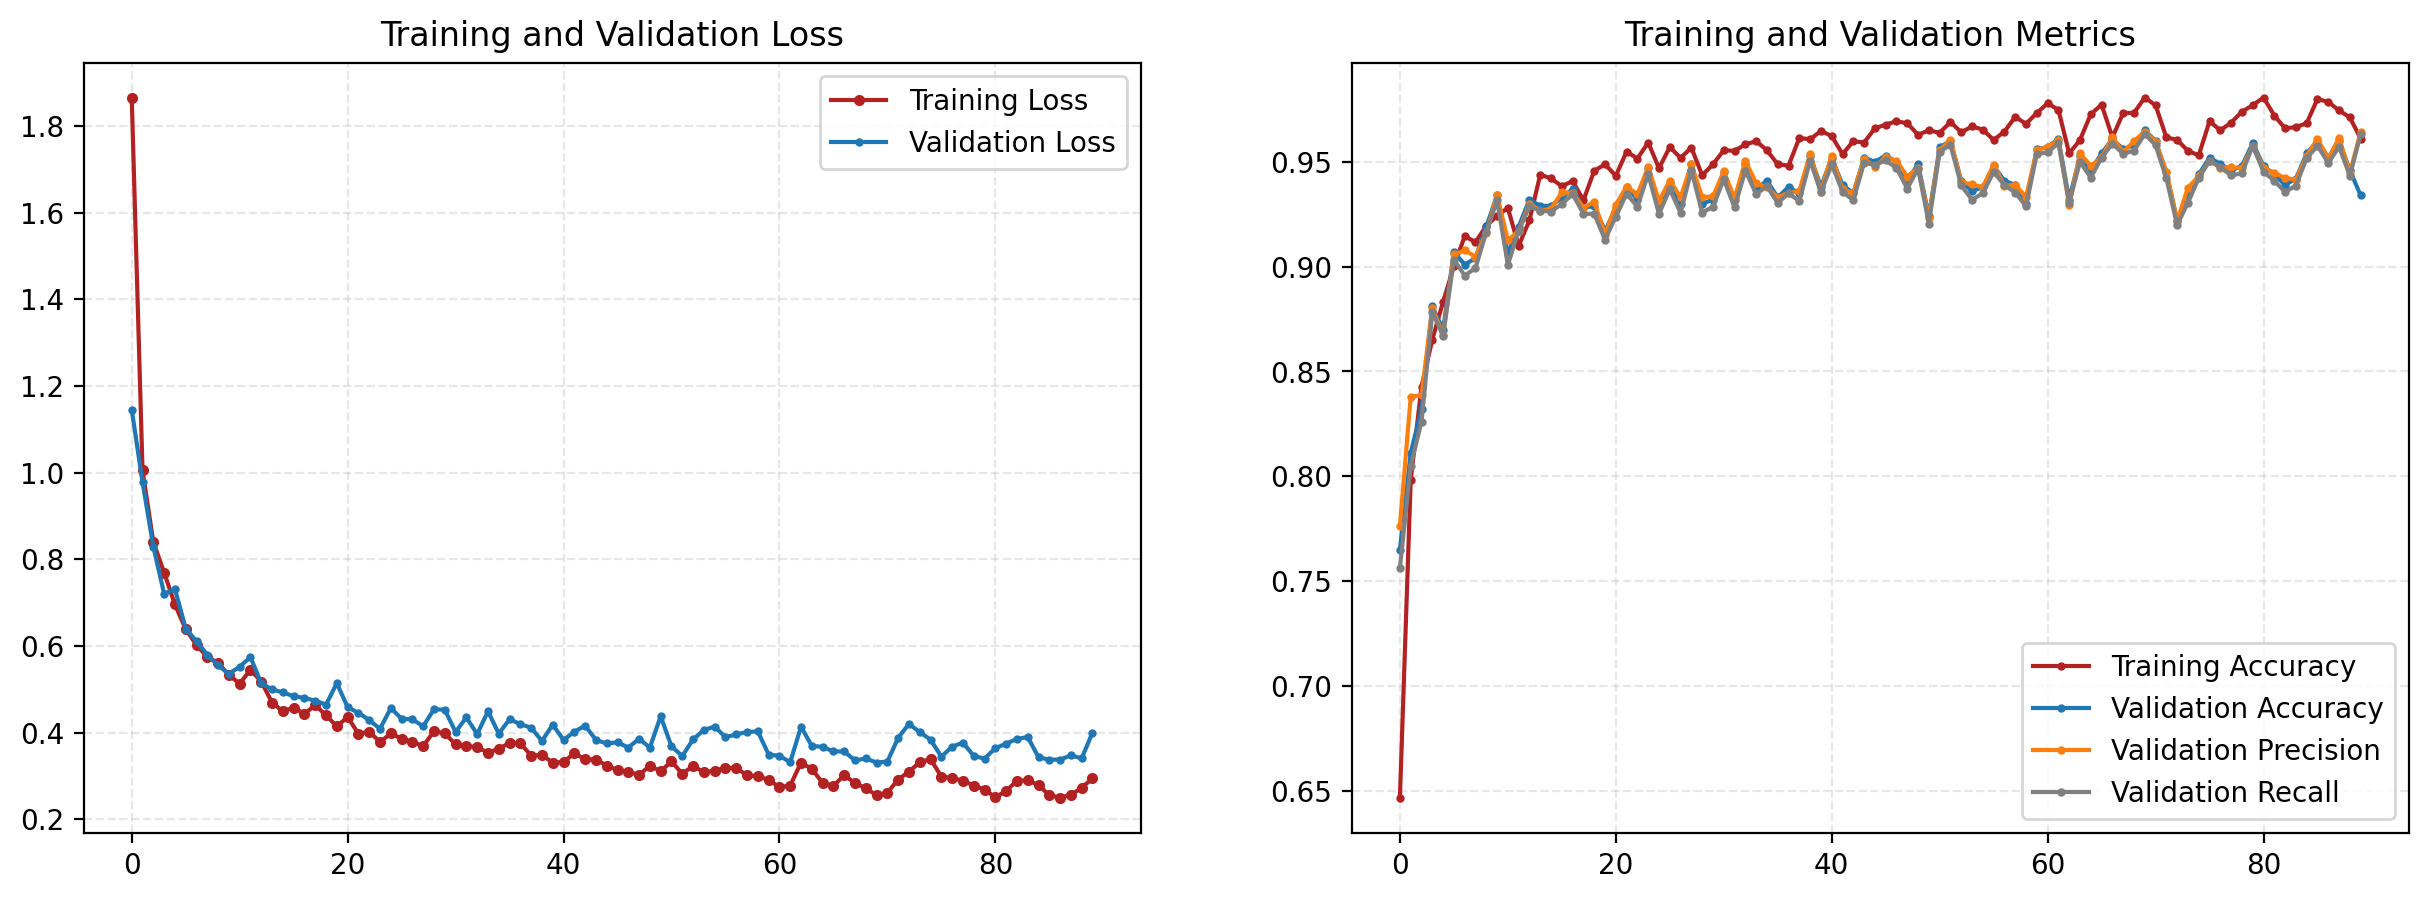

In [122]:
# Plot the learning curves with all the metrics
plotHistory(history, precision_recall_callback)

Although the curves inherent to the validation set are somewhat 'bumpy' compared to those of the training set, an absolutely successful trend can be observed: the Loss Function is rapidly minimised to a plateau region after about $40$ epochs, while the accuracy rises, for both sets, above a value of $95\%$.\
The plot also shows the trend of __precision__ and __recall__ on the validation set (averaged over all classes in *macro*) which, on such a balanced dataset, are indeed indicators of the model's ability to detect True Positives and overlap almost perfectly with the accuracy on the validation set.

Remember that $precision \equiv \frac{TP}{TP+FP}$ and $recall \equiv \frac{TP}{TP+FN}$.

In [123]:
# Transform the test set according to the PCA projection and the clustering algorithm
import pickle
from sklearn.decomposition import PCA

# Load the PCA model
with open('models/pca.pickle', 'rb') as file:
    pca_model = pickle.load(file)

# Load the clustering model
with open('models/gm.pickle', 'rb') as file:
    gm_model = pickle.load(file)

In [124]:
# Transform the test set according to the PCA model (X_test is already scaled)
principal_components = pca_model.transform(X_test)
pc_X_test = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(len(X_train.columns[:-1]))])

import warnings
warnings.filterwarnings('ignore')

# Get the probabilities for each point in the test set
X_test_new = getProbabilities(gm_model, pc_X_test)

In [125]:
# Evaluate the model on the test set (we have already removed the SN Type IIL from the test set 
# and mapped the labels to integers)
model.evaluate(X_test_new, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 1.6156 - accuracy: 0.6707


[1.6156457662582397, 0.6706827282905579]

Unfortunately we are definitely overfitting on the test set. __Why__? Probably due to the strong imbalance between the classes also in the test set, where we have only $250$ instances.\
Let us now look at the __confusion matrix__ to better understand the nature of the problem.

In [126]:
# Invert keys and values in the mapping dictionary
inv_mapping_dict = {v: k for k, v in mapping_dict.items()}

In [127]:
# Plot the confusion matrix on the test set
from python_scripts.unsupervised import *

# Transform the label arrays into dataframes with correct mapping
y_test_new = pd.DataFrame(y_test.map(inv_mapping_dict), columns=['SNTYPE'])

# Make predictions on the test set
y_pred = model.predict(X_test_new)
# Determine the predicted class labels
y_pred = np.argmax(y_pred, axis=1)
# Transform the predicted labels into a dataframe
y_pred = pd.DataFrame(y_pred, columns=['SNTYPE'])
# Map the predicted labels to the correct SN Type
y_pred_new = y_pred['SNTYPE'].map(inv_mapping_dict)

8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step - loss: 1.6156 - accuracy: 0.6707


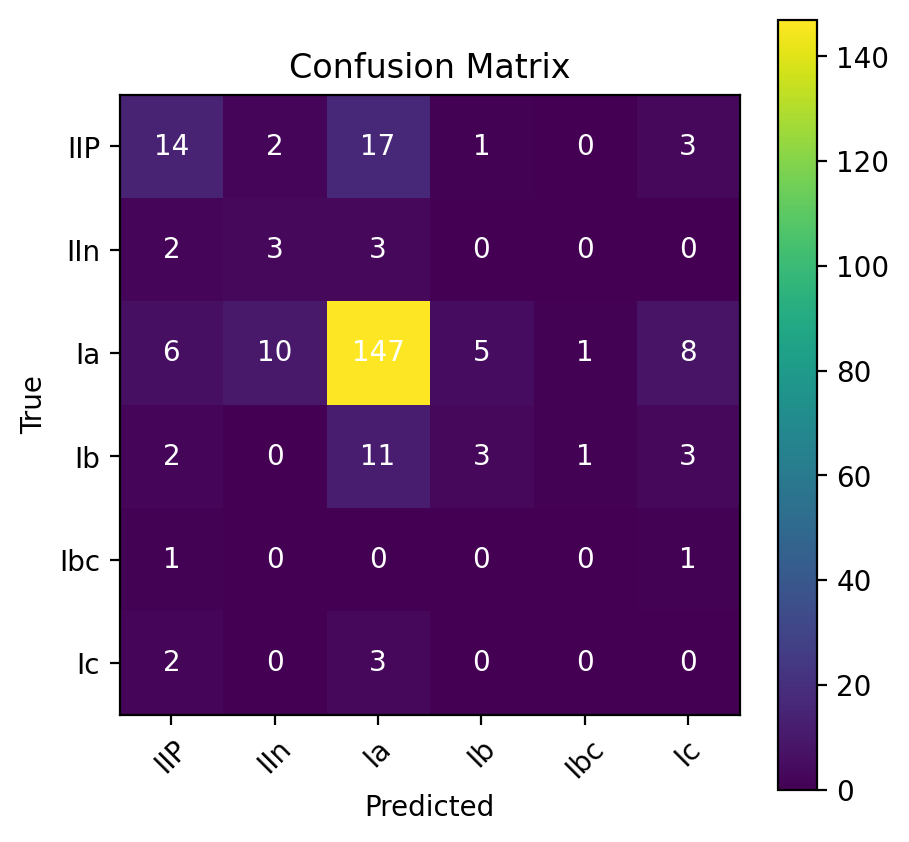

--------------------Classification Report--------------------
              precision    recall  f1-score   support

         IIP       0.52      0.38      0.44        37
         IIn       0.20      0.38      0.26         8
          Ia       0.81      0.83      0.82       177
          Ib       0.33      0.15      0.21        20
         Ibc       0.00      0.00      0.00         2
          Ic       0.00      0.00      0.00         5

    accuracy                           0.67       249
   macro avg       0.31      0.29      0.29       249
weighted avg       0.69      0.67      0.67       249



In [128]:
# Evaluate the model on the test set
model.evaluate(X_test_new, y_test)

# Plot the confusion matrix with the classification report
plot_confusion_matrix(y_test_new, y_pred_new, size=(5, 5), want_report=True)

As you can see, we have very few instances of True Positives for all the classes with except for the Ia events.

<font color='orange'>OBS</font>:
One could think that it would be sufficient to perform __data augmentation__ also on the test set, but this is generally not recommended. The purpose of the test set is to provide an unbiased evaluation of the model's generalization to unseen data. By artificially augmenting the test set, we may introduce biases that compromise the integrity of the evaluation.\
One of the main risks is __Data Leakage__: the test set should be entirely independent of the training set. When augmenting the test set we might introduce patterns or information from the training set into the test set, leading to data leakage. 

#### __4. Variations__
__1. Remove Principal Components__\
What if we drastically reduce the number of features? Remember that, during PCA, we identified the elbow point to be at $6$ principal components. Let's try with that.

In [129]:
# Drop the 'useless' PCs from the training, test and validation sets
reduced_X_train = X_train.drop(X_train.columns[6:-1], axis=1)
reduced_X_test = X_test_new.drop(X_test_new.columns[6:-1], axis=1)
reduced_X_val = X_val.drop(X_val.columns[6:-1], axis=1)

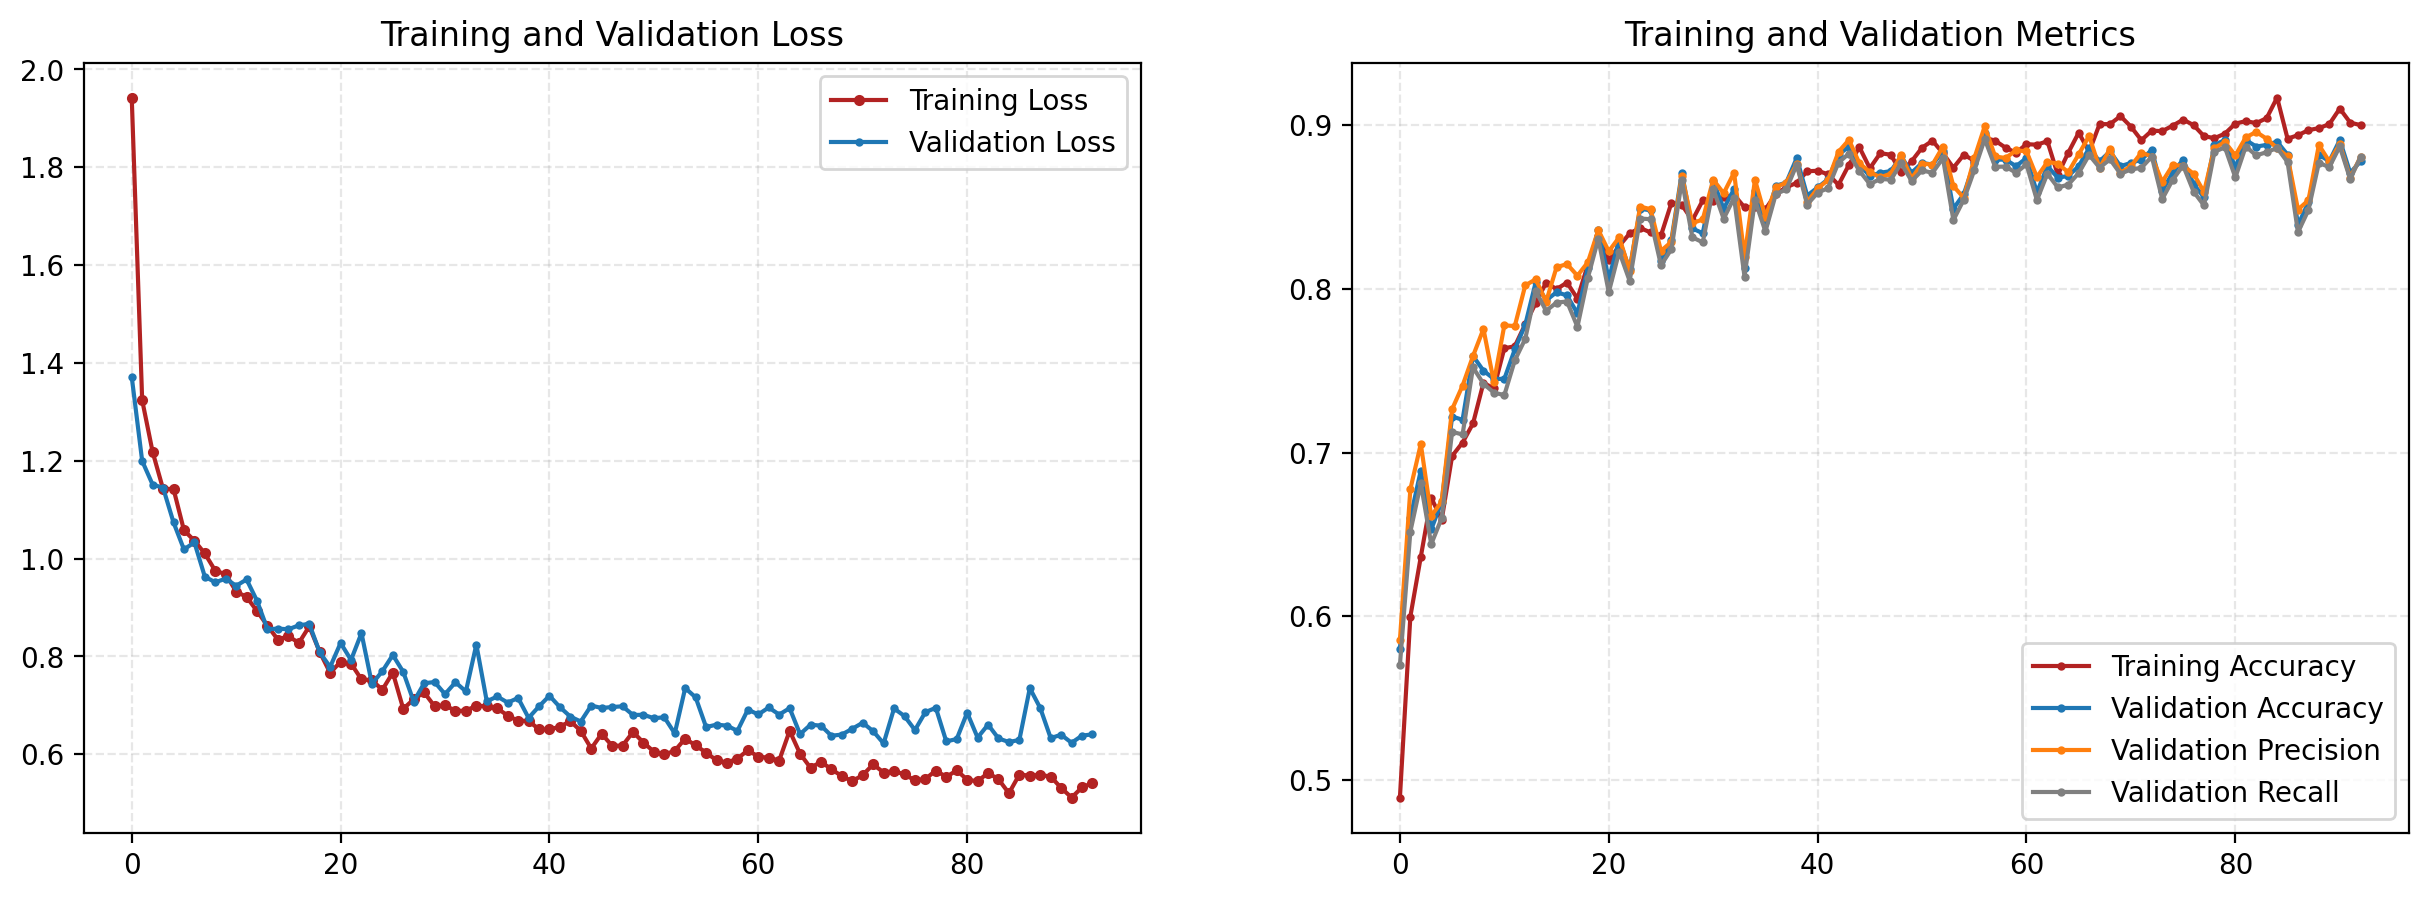

In [130]:
from python_scripts.supervised import *
model, time_2 = trainPipeline(reduced_X_train, y_train, reduced_X_val, y_val)

8/8 [==============================] - 0s 2ms/step


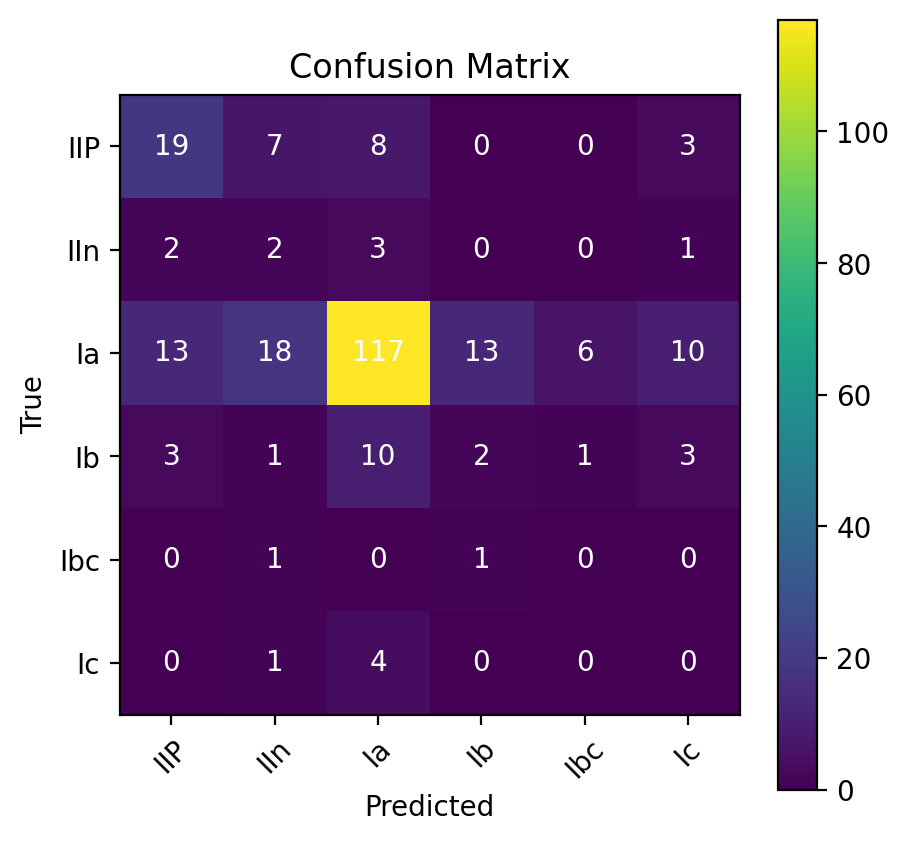

--------------------Classification Report--------------------
              precision    recall  f1-score   support

         IIP       0.51      0.51      0.51        37
         IIn       0.07      0.25      0.11         8
          Ia       0.82      0.66      0.73       177
          Ib       0.12      0.10      0.11        20
         Ibc       0.00      0.00      0.00         2
          Ic       0.00      0.00      0.00         5

    accuracy                           0.56       249
   macro avg       0.25      0.25      0.24       249
weighted avg       0.67      0.56      0.61       249



In [131]:
# Transform also the test set
reduced_X_test_new = X_test_new.drop(X_test_new.columns[6:-1], axis=1)

# Evaluate the model on the test set
model.evaluate(reduced_X_test_new, y_test)

# Make predictions on the test set
y_pred = model.predict(reduced_X_test_new)
# Determine the predicted class labels
y_pred = np.argmax(y_pred, axis=1)
# Transform the predicted labels into a dataframe
y_pred = pd.DataFrame(y_pred, columns=['SNTYPE'])
# Map the predicted labels to the correct SN Type
y_pred_new = y_pred['SNTYPE'].map(inv_mapping_dict)

# Plot the confusion matrix with the classification report
plot_confusion_matrix(y_test_new, y_pred_new, size=(5, 5), want_report=True)

During training, it can be observed how the model manages to achieve excellent performance even with a considerably reduced number of features (less than half of the original features): the Principal Component Analysis has thus correctly identified the directions of maximum variance and, by dispensing with the information produced by as many as $9$ features, an accuracy on the validation set of over 90% is achieved.
On the other hand, the generalisation on the test set is definitely weaker; however, as we have seen above, this evaluation is not too reliable.

__2. Remove Clustering Information__\
What if we reduce the `PROBABILITY` feature from the reduced dataset? Remember that it represents the probability of the point to belong to Type I or Type II SN events.

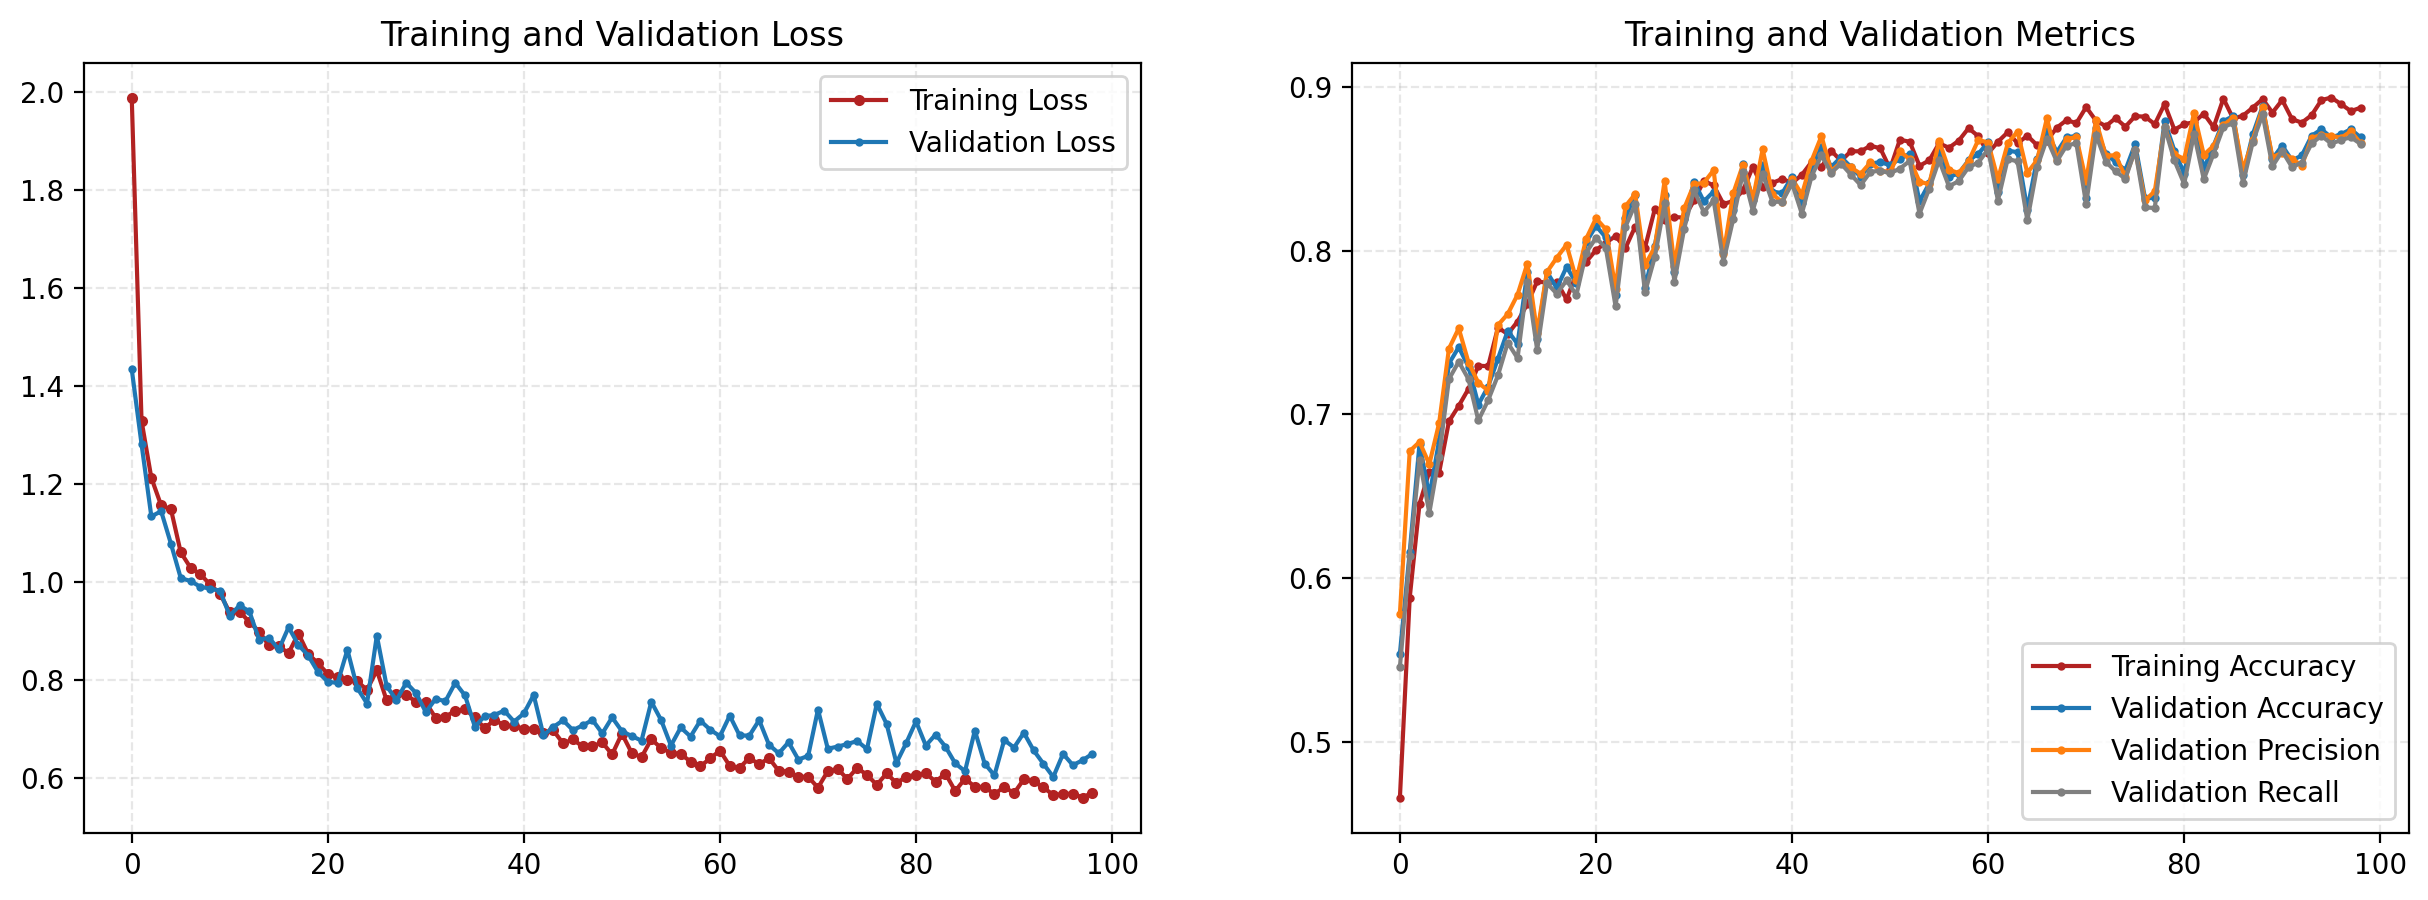

In [132]:
# Drop the PROBABILITY column from the training, test and validation sets
no_prob_X_train = reduced_X_train.drop(['PROBABILITY'], axis=1)
no_prob_X_test = reduced_X_test.drop(['PROBABILITY'], axis=1)
no_prob_X_val = reduced_X_val.drop(['PROBABILITY'], axis=1)

# Train the model on the training set
model, time_3 = trainPipeline(no_prob_X_train, y_train, no_prob_X_val, y_val)

8/8 [==============================] - 0s 2ms/step


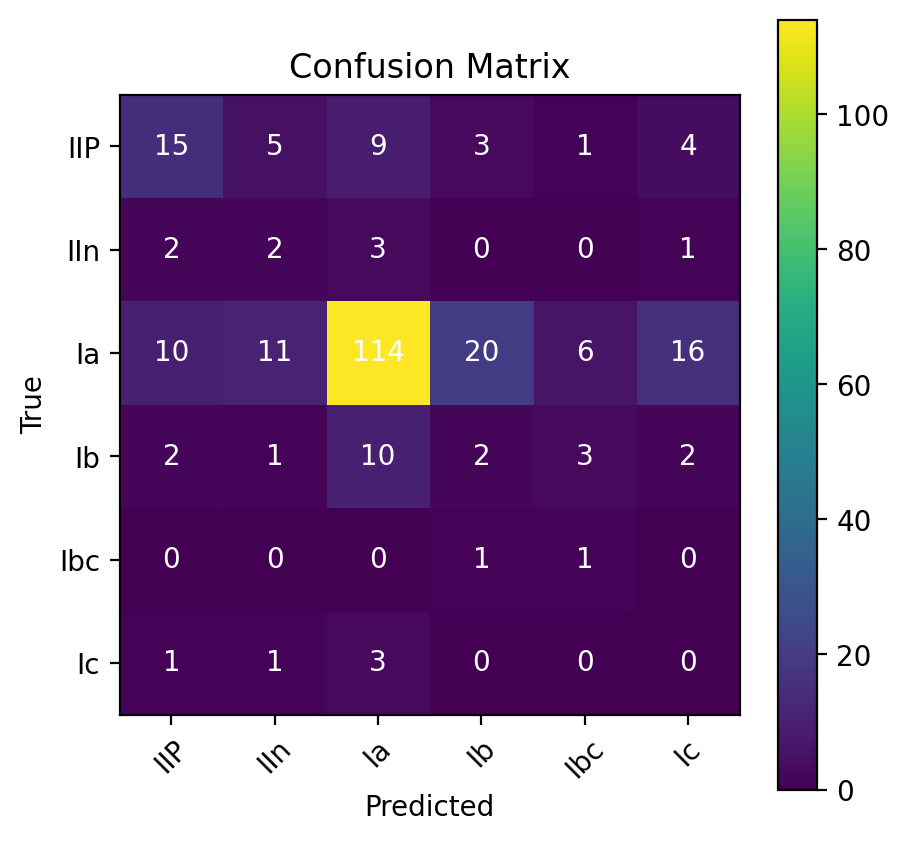

--------------------Classification Report--------------------
              precision    recall  f1-score   support

         IIP       0.50      0.41      0.45        37
         IIn       0.10      0.25      0.14         8
          Ia       0.82      0.64      0.72       177
          Ib       0.08      0.10      0.09        20
         Ibc       0.09      0.50      0.15         2
          Ic       0.00      0.00      0.00         5

    accuracy                           0.54       249
   macro avg       0.26      0.32      0.26       249
weighted avg       0.67      0.54      0.59       249



In [133]:
# Evaluate the model on the test set
model.evaluate(no_prob_X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(no_prob_X_test)
# Determine the predicted class labels
y_pred = np.argmax(y_pred, axis=1)
# Transform the predicted labels into a dataframe
y_pred = pd.DataFrame(y_pred, columns=['SNTYPE'])
# Map the predicted labels to the correct SN Type
y_pred_new = y_pred['SNTYPE'].map(inv_mapping_dict)

# Plot the confusion matrix with the classification report
plot_confusion_matrix(y_test_new, y_pred_new, size=(5, 5), want_report=True)

The performance of the latter configuration is actually better than that including the probability from the clustering process.
This tells us that the dataset is very difficult to separate, with clusters that are very overlapping and not very symmetrical.\
Instead, the neural network was able to distinguish the classes correctly, having the correct labels available.

__3. Remove Clustering Information from the whole dataset__\
Finally repeat the `PROBABILITY` removal on the original 16-D dataset.

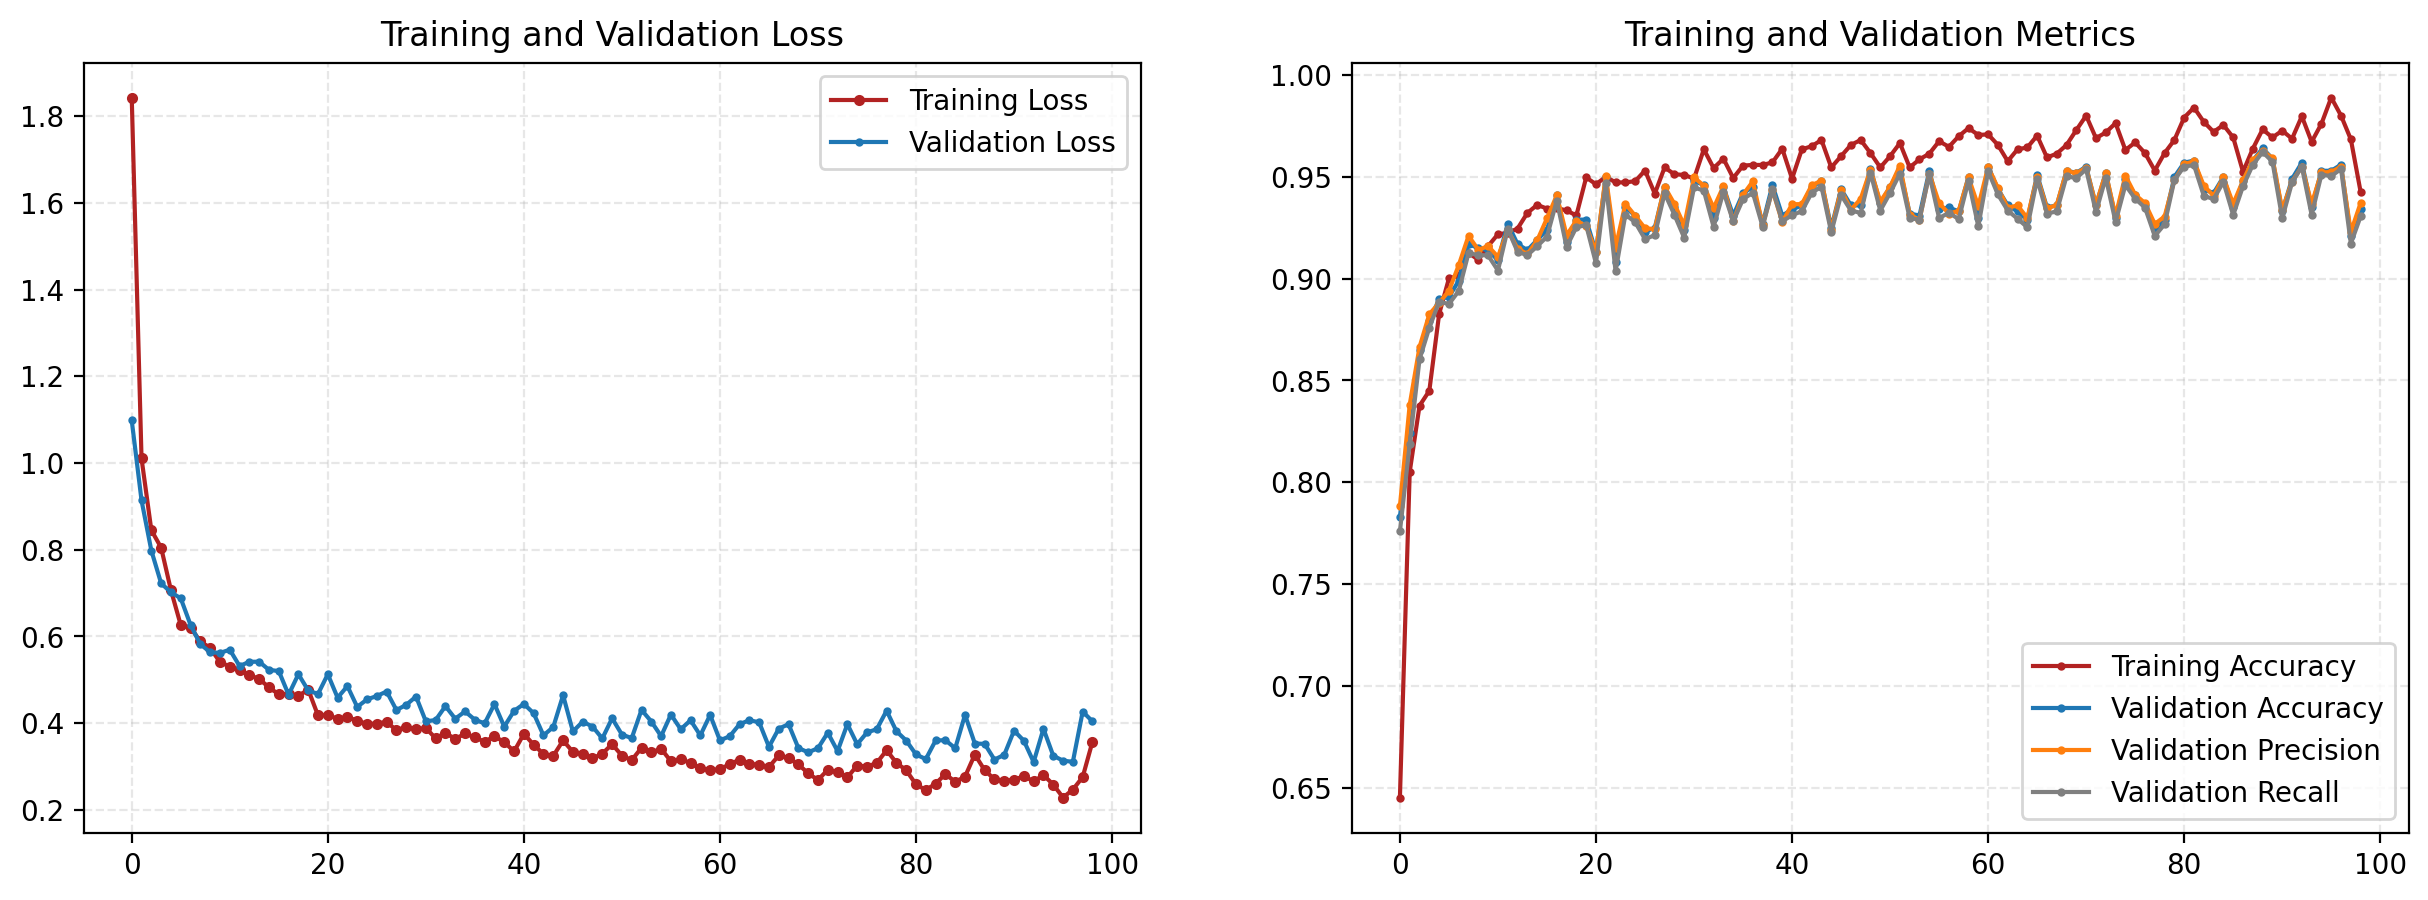

In [134]:
# Drop the PROBABILITY column from the training, test and validation sets
no_prob_X_train = X_train.drop(['PROBABILITY'], axis=1)
no_prob_X_test = X_test_new.drop(['PROBABILITY'], axis=1)
no_prob_X_val = X_val.drop(['PROBABILITY'], axis=1)

# Train the model on the training set
model, time_4 = trainPipeline(no_prob_X_train, y_train, no_prob_X_val, y_val)

# Save the model for later use
model.save('models/final_model.h5')

1/8 [==>...........................] - ETA: 0s - loss: 1.5456 - accuracy: 0.7188

8/8 [==============================] - 0s 2ms/step


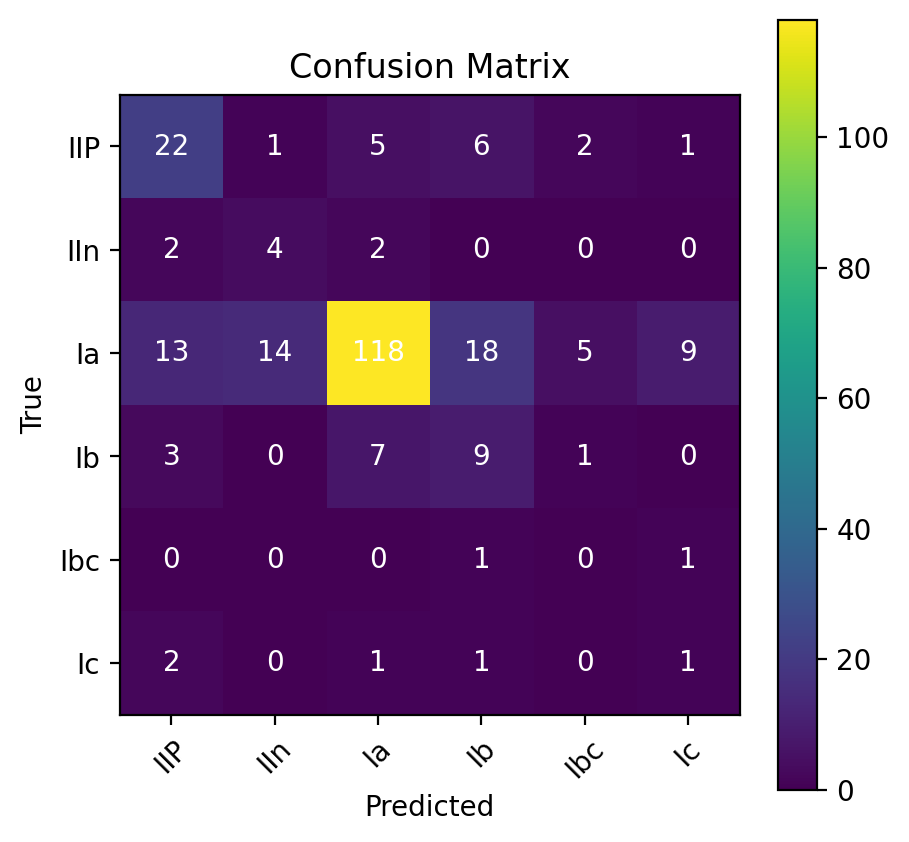

--------------------Classification Report--------------------
              precision    recall  f1-score   support

         IIP       0.52      0.59      0.56        37
         IIn       0.21      0.50      0.30         8
          Ia       0.89      0.67      0.76       177
          Ib       0.26      0.45      0.33        20
         Ibc       0.00      0.00      0.00         2
          Ic       0.08      0.20      0.12         5

    accuracy                           0.62       249
   macro avg       0.33      0.40      0.34       249
weighted avg       0.74      0.62      0.66       249



In [135]:
# Evaluate the model on the test set
model.evaluate(no_prob_X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(no_prob_X_test)
# Determine the predicted class labels
y_pred = np.argmax(y_pred, axis=1)
# Transform the predicted labels into a dataframe
y_pred = pd.DataFrame(y_pred, columns=['SNTYPE'])
# Map the predicted labels to the correct SN Type
y_pred_new = y_pred['SNTYPE'].map(inv_mapping_dict)

# Plot the confusion matrix with the classification report
plot_confusion_matrix(y_test_new, y_pred_new, size=(5, 5), want_report=True)

### __5. Binary Classification__
Finally, we train the same Neural Network using Binary Classification, trying to alleviate the imbalance problem. We divide the dataset into instances of type `Ia` and type `Other` and we check if the model can ultimately reach a better generalization power.

In [136]:
# Redeclare the mapping dictionary to include the SN Type IIL
mapping_dict = {'Ia': 0, 'Ib': 1, 'Ic': 2, 'Ibc': 3, 'IIP': 4, 'IIn': 5, 'IIL': 6}
# Collect all I SNs into one class and all II SNs into another class
label_mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}

In [137]:
# Fetch the data from the csv files inside the data folder named final_datasets
X_train = pd.read_csv('final_datasets/X_train_new.csv')
X_test = pd.read_csv('final_datasets/X_test.csv')
y_train = pd.read_csv('final_datasets/y_train.csv')
y_test = pd.read_csv('final_datasets/y_test.csv')

# Map the labels to integers
y_train = y_train['SNTYPE'].map(mapping_dict)
y_test = y_test['SNTYPE'].map(mapping_dict)

# Map the labels to the new labels
binary_y_train = y_train.map(label_mapping)
binary_y_test = y_test.map(label_mapping)

In [138]:
# Final balance of the training set
print('Training Set:\n',binary_y_train.value_counts())
print('\n')

# Final balance of the test set
print('Test Set:\n', binary_y_test.value_counts())

Training Set:
 SNTYPE
0    702
1    298
Name: count, dtype: int64


Test Set:
 SNTYPE
0    177
1     73
Name: count, dtype: int64


In [139]:
# Define the validation set (we can use the last 200 instances of the training set since we have already shuffled the data)
X_val = X_train[-200:]
binary_y_val = binary_y_train[-200:]
X_train = X_train[:-200]
binary_y_train = binary_y_train[:-200]

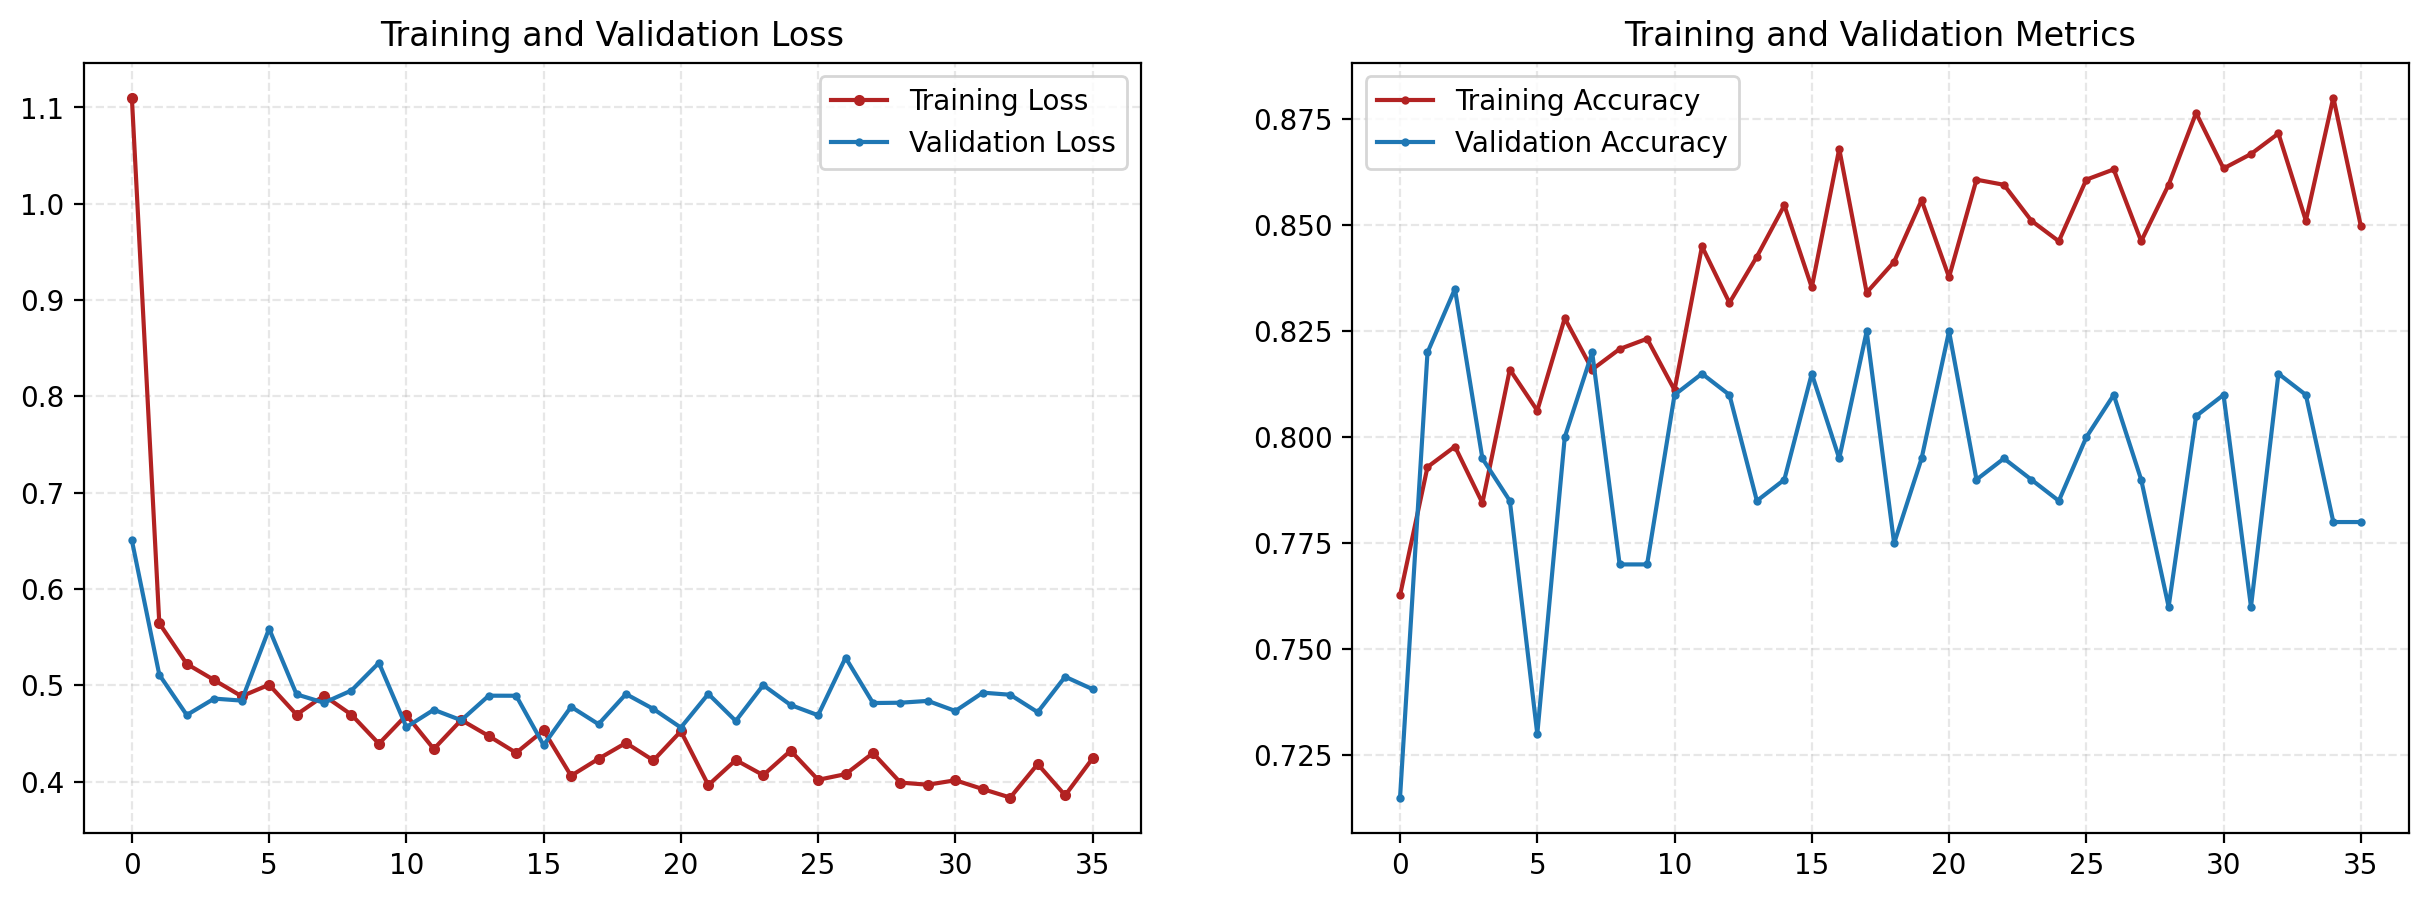

In [140]:
# Create the model and train it on the training set
model, time_5 = trainPipeline(X_train, binary_y_train, X_val, binary_y_val, classes=2, want_callback=False)

8/8 [==============================] - 0s 2ms/step


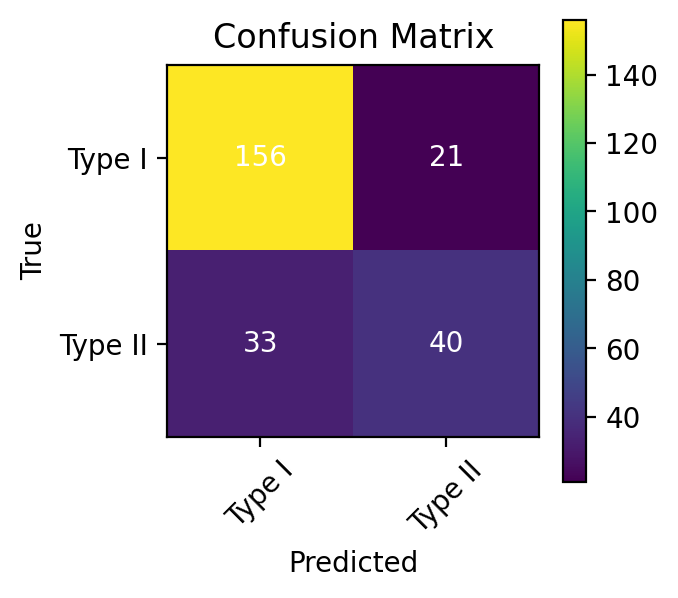

--------------------Classification Report--------------------
              precision    recall  f1-score   support

      Type I       0.83      0.88      0.85       177
     Type II       0.66      0.55      0.60        73

    accuracy                           0.78       250
   macro avg       0.74      0.71      0.72       250
weighted avg       0.78      0.78      0.78       250



In [141]:
# Transform the test set according to the PCA model (X_test is already scaled)
# We need to do this since previously we excluded the SN Type IIL from the test set
principal_components = pca_model.transform(X_test)
pc_X_test = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(len(X_train.columns[:-1]))])

import warnings
warnings.filterwarnings('ignore')

# Get the probabilities for each point in the test set
X_test_new = getProbabilities(gm_model, pc_X_test)

# Evaluate the model on the test set
model.evaluate(X_test_new, binary_y_test)

# Make predictions on the test set
y_pred = model.predict(X_test_new)

# Determine the predicted class labels: here we need to set a threshold of 0.5
y_pred = np.where(y_pred > 0.5, 1, 0)

# Transform the predicted labels into a dataframe
y_pred = pd.DataFrame(y_pred, columns=['SNTYPE'])
y_test_new = pd.DataFrame(binary_y_test, columns=['SNTYPE'])

# Map the predicted labels to the correct SN Type
y_pred_new = y_pred['SNTYPE'].map({0: 'Type I', 1: 'Type II'})
y_test_new = y_test_new['SNTYPE'].map({0: 'Type I', 1: 'Type II'})

# Plot the confusion matrix with the classification report
plot_confusion_matrix(y_test_new, y_pred_new, size=(3, 3), want_report=True)

Recall the following concepts:

__ROC Curve__:\
The ROC curve is a graphical representation of the trade-off between true positive rate (*sensitivity*) and false positive rate ($1-$ *specificity*) across different threshold values. Here are the key components of the ROC curve:

- *Sensitivity*: represents the proportion of actual positive instances correctly predicted by the model. Mathematically, it is defined as $ \text{Sensitivity} = \frac{\text{TPR}}{\text{True Positives + False Negatives}} $.

- $1-$ *Specificity*: represents the proportion of actual negative instances incorrectly predicted as positive by the model. Mathematically, it is defined as $ \text{(1 - Spec)} = \frac{\text{False Positives}}{\text{False Positives + True Negatives}} $.

- *Threshold Variation*: the ROC curve is generated by varying the classification threshold of the model and plotting the true positive rate against the false positive rate at each threshold.

A diagonal line (the *no-discrimination line*) is represented by the $45$-degree line, and the better the model, the closer the ROC curve is to the upper-left corner of the plot, since the *no-discrimination line* represents random guessing.

__AUC Score__:
The Area Under the Curve (AUC) score quantifies the overall performance of a model based on its ROC curve. It represents the area under the ROC curve.

8/8 [==============================] - 0s 2ms/step


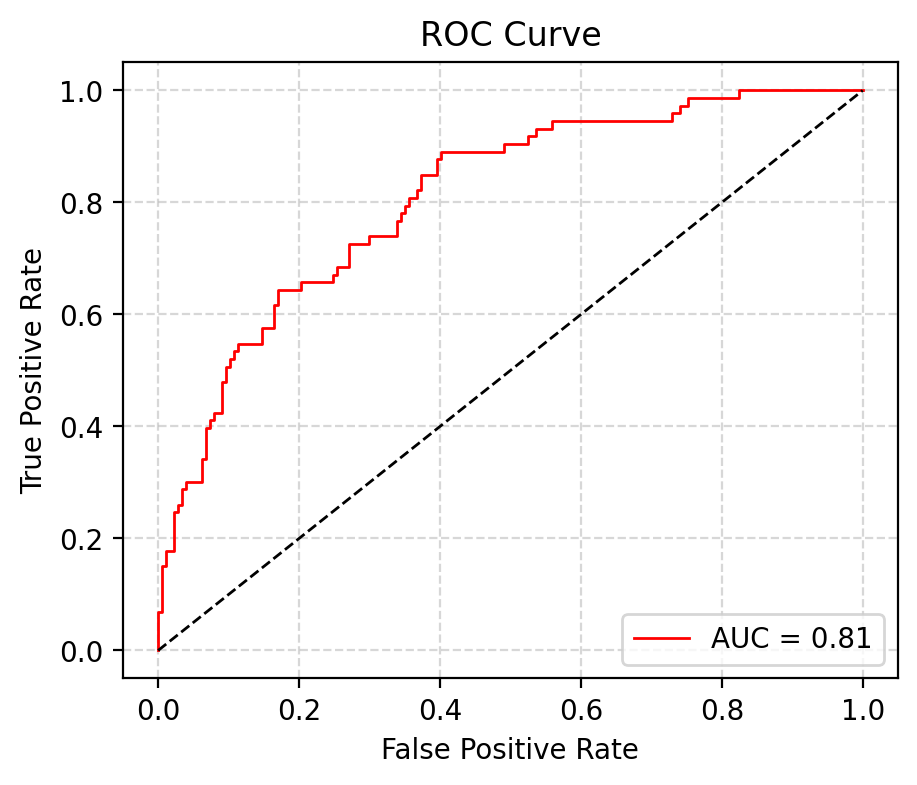

In [142]:
# Finally, plot the ROC curve and compute the AUC score
from sklearn.metrics import roc_curve, auc

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(binary_y_test, model.predict(X_test_new))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='red', lw=1, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Having said all this, we can finally conclude that this model, trained on a much smaller dataset size but with only two possible classes, *demonstrates* $^{[3]}$ greater power of generalisation, with an error on the test set compatible with that on the validation and training set. On the other hand, the final accuracy on the training set, as well as precision and recall, are lower than with the multiclass classifier, a clear symptom of underfitting due to the shortage of data points.\

<font size=2>

$[3]$: The term *demonstrates* is used because we previously evaluated the multiclass model on a strongly unbalanced test set.